<h1 align="center">Regression Model for Predicting Wine Quality</h1>

## Introduction {#intro}

This notebook aims to accomplish [Regression Model](https://algorit.ma/course/regression-models/) course at Algoritma. The dataset used is obtained from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wine+Quality), i.e. Wine Quality Data Set. There are two datasets provided (red wine and white wine), but **only the white wine one will be discussed in this notebook.**

### Dataset Background

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult: [Web Link](http://www.vinhoverde.pt/en/) or the reference [Cortez et al., 2009](http://dx.doi.org/10.1016/j.dss.2009.05.016). Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.

### Aim

The goal is to model wine quality based on physicochemical tests.

### Objectives

a. To solve the final model equation

b. To output the statistical values (adjusted) R-squared and Root Mean Squared Error (RMSE)

c. To examine the model including statistics and visualizations:

- Assess linearity of model (parameters)
- Assess serial independence of errors
- Assess heteroscedasticity
- Assess normality of residual distribution
- Assess multicollinearity

d. To interpretate the model

e. To consider other factors, such as:

- Are there any outliers?
- Are there missing values?
- How will categorical variables be handled?

f. To test the model using dataset test and discuss the results

### Structure

This article is arranged as follows.

1. [Introduction](#intro)
2. [Metadata](#meta)
3. [Preparation](#prep)
4. [Exploratory Data Analysis](#eda)
5. [Modelling](#model)
6. [Model Improvements](#modimprov)
7. [Results and Discussions](#resdis)
8. [Conclusions](#conc)

## Metadata {#meta}

There are 12 columns available in the dataset. They are briefly described below or you can read in [this file](winequality.names). For more information, read [Cortez et al., 2009](http://dx.doi.org/10.1016/j.dss.2009.05.016).

Input variables (based on physicochemical tests):

1. fixed acidity
2. volatile acidity
3. citric acid
4. residual sugar
5. chlorides
6. free sulfur dioxide
7. total sulfur dioxide
8. density
9. pH
10. sulphates
11. alcohol

Output variable (based on sensory data):

12. quality (score between 0 and 10)

### Source

Paulo Cortez, University of Minho, Guimarães, Portugal, http://www3.dsi.uminho.pt/pcortez
A. Cerdeira, F. Almeida, T. Matos and J. Reis, Viticulture Commission of the Vinho Verde Region(CVRVV), Porto, Portugal @2009

### Relevant Papers

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties.
In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

Available at: [Web Link](http://dx.doi.org/10.1016/j.dss.2009.05.016)

## Preparation {#prep}

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy.stats.stats import pearsonr
import statsmodels.api as smApi

%matplotlib inline

Prepare the performance indicators and all necessary functions.

In [6]:
def indicator(model, X_train, y_train, y_pred, y_true):
    Rsq = model.score(X_train, y_train)
    n = X_train.shape[0]
    p = X_train.shape[1]
    adjRsq = 1 - (1- Rsq**2)*((n-1)/(n-p-1))
    print('Adj R-squared:', adjRsq)
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_pred, y_true))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_pred, y_true))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_pred, y_true)))

def Metrics(y_pred, y_true):
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_pred, y_true))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_pred, y_true))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_pred, y_true)))
    corPredAct = pearsonr(y_pred, y_true)
    print("Correlation:", corPredAct)
    print("R^2 between y_pred & y_true:", corPredAct[0]**2)

import scipy.stats
def CheckNormal(model, X, y):
    y_hat = model.predict(X)
    residue = y - y_hat
    plt.hist(residue, bins=30)
    shaptest = stats.shapiro(residue)[1]
    print('p-value:', shaptest)
    if (shaptest <= 0.05):
        print("H0 rejected: the residuals are NOT distributed normally")
    else:
        print("H0 failed to reject: the residuals ARE distributed normally")

import statsmodels.stats as smStats
def CheckHomos(model, X, y):
    y_hat = model.predict(X)
    residue = y - y_hat
    
    fig = plt.figure()
    plt.plot(y_hat, residue)
    plt.plot(np.arange(len(y_hat)), np.zeros(len(residue)), color = "red")

    
    BP = smStats.het_breuschpagan(residue)
    print(BP)
    if (BP.value <= 0.05):
        print("H0 rejected: Error variance spreads INCONSTANTLY/generating patterns(Heteroscedasticity)")
    else:
        print("H0 failed to reject: Error variance spreads CONSTANTLY (Homoscedasticity)")

In [20]:
scipy.stats.pearsonr(whiteDF.quality, whiteDF.alcohol)

(0.4355747154613862, 5.614770253567633e-226)

In [7]:
whiteDF = pd.read_csv('winequality-white.csv', delimiter=";")
whiteDF.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [8]:
whiteDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [9]:
whiteDF.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [10]:
whiteDF.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

## Exploratory Data Analysis

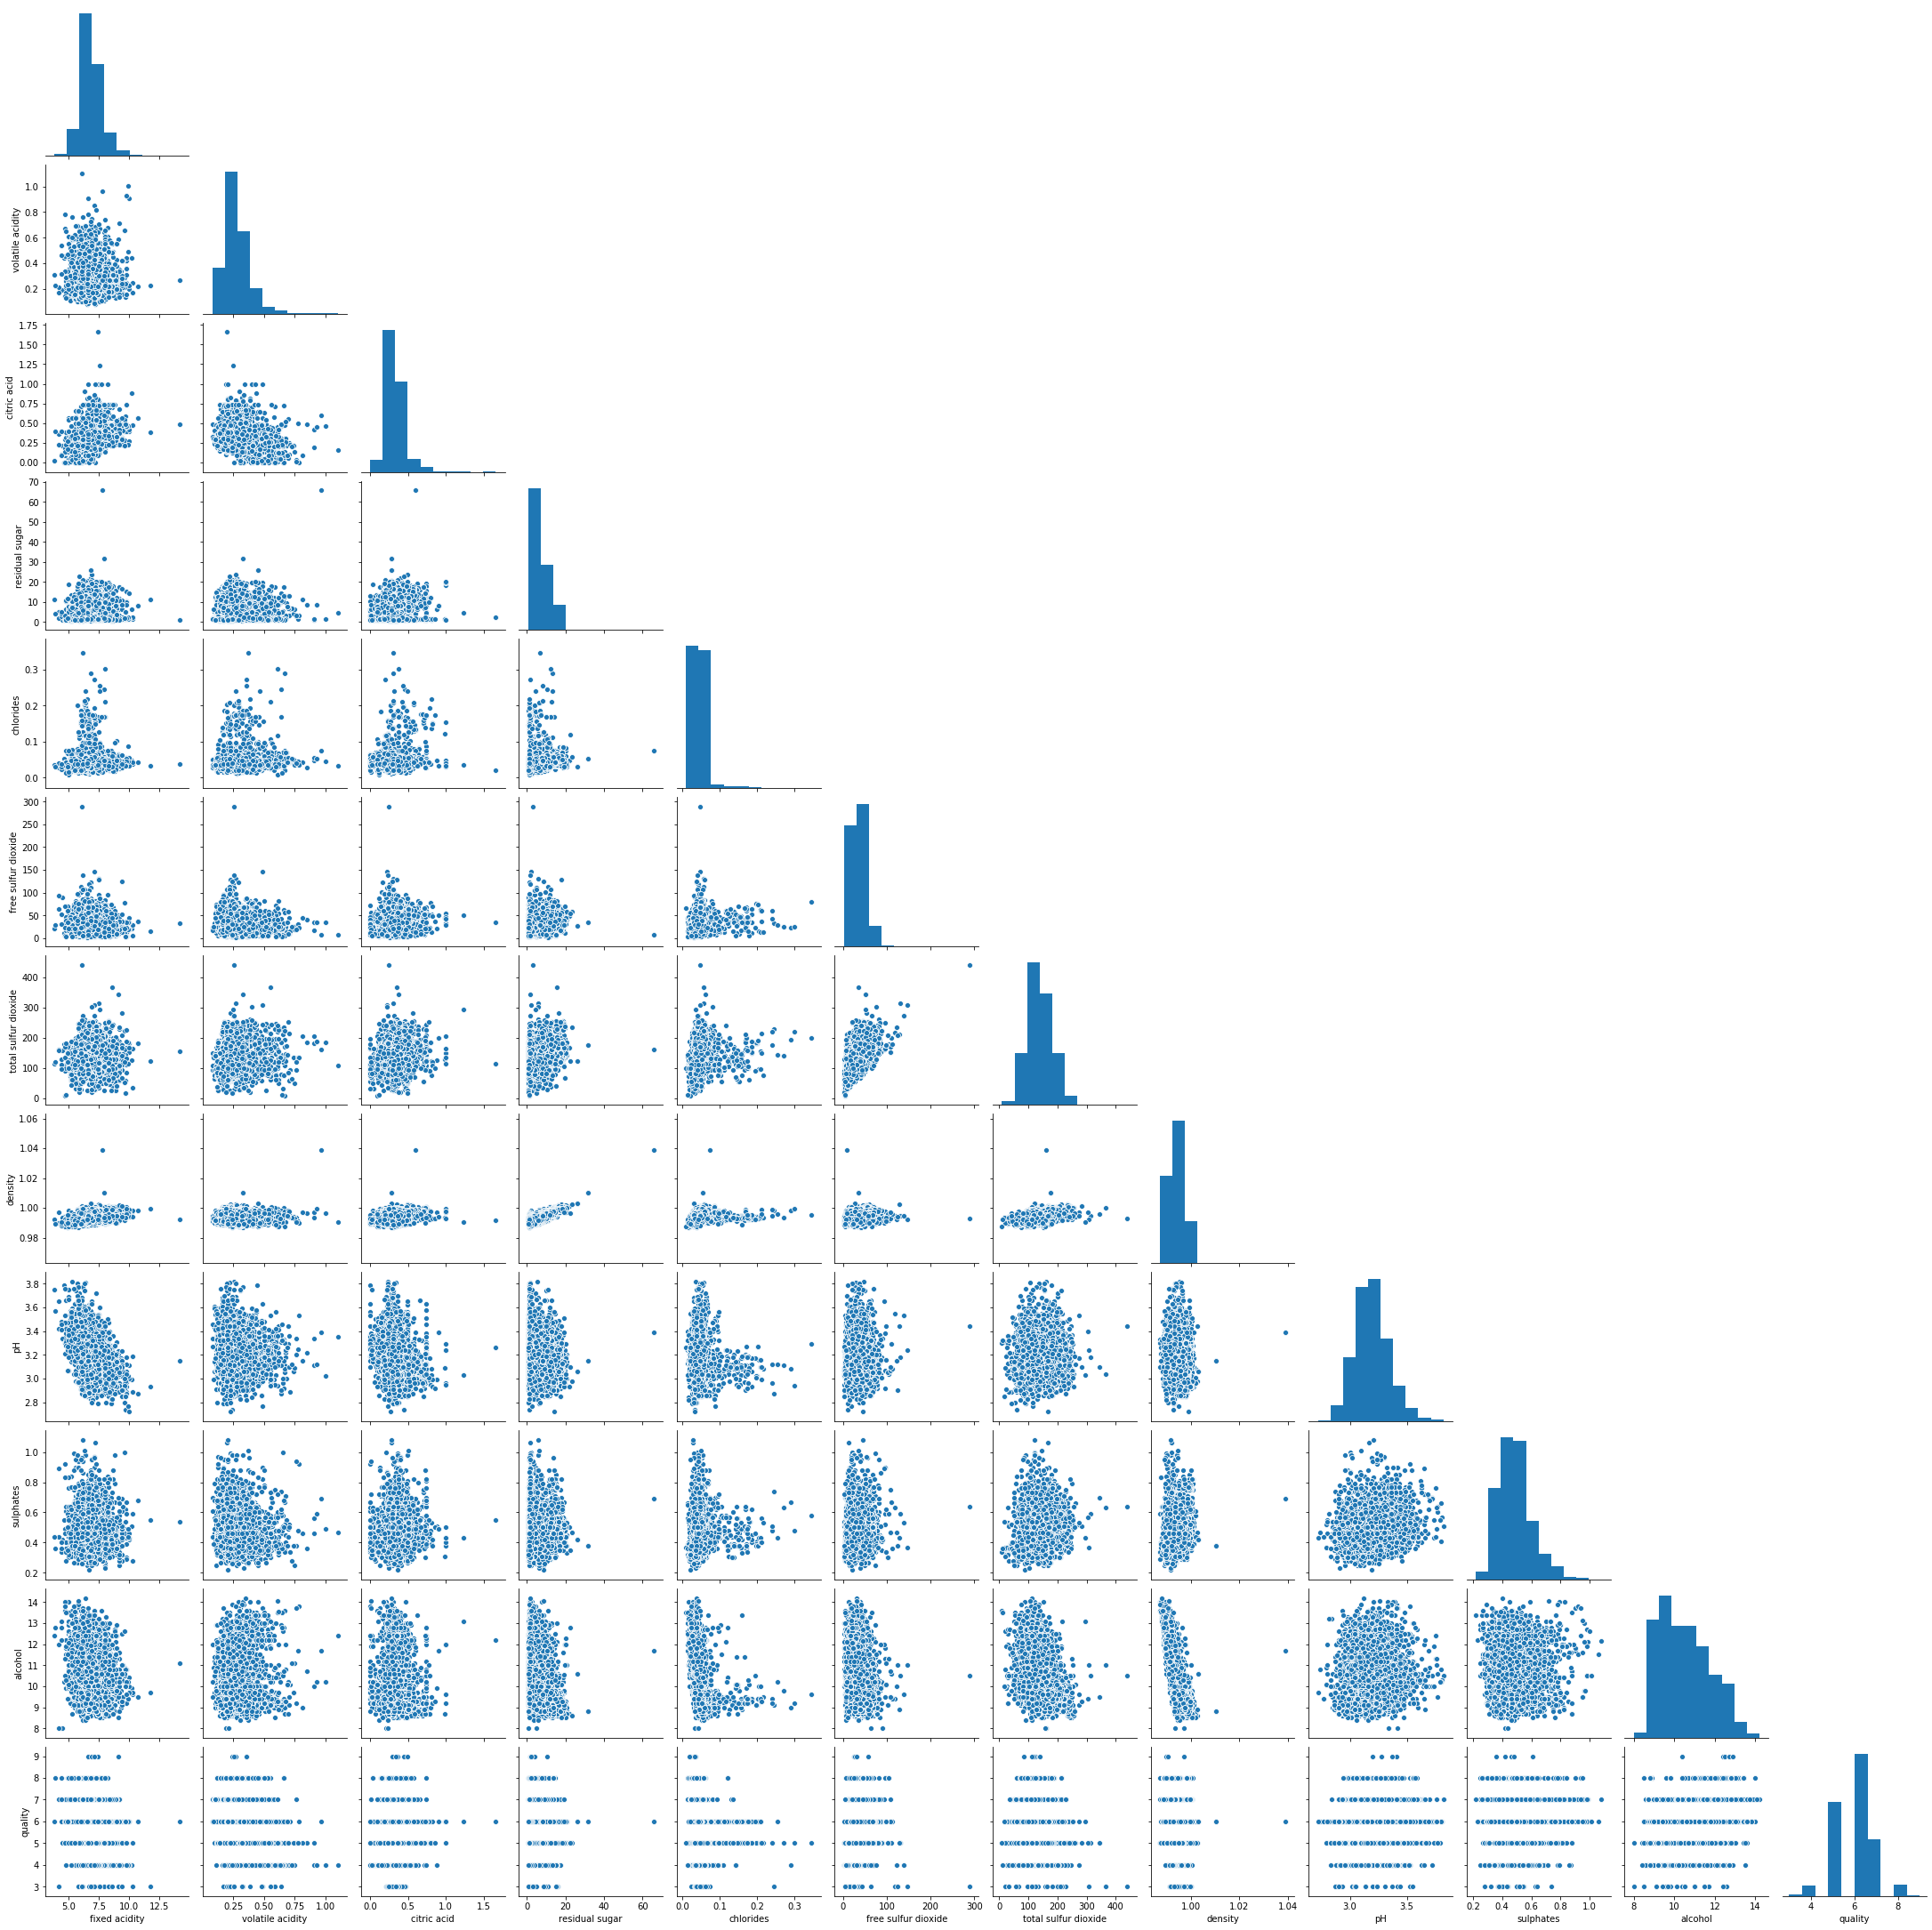

In [13]:
sns.pairplot(whiteDF, corner = True)

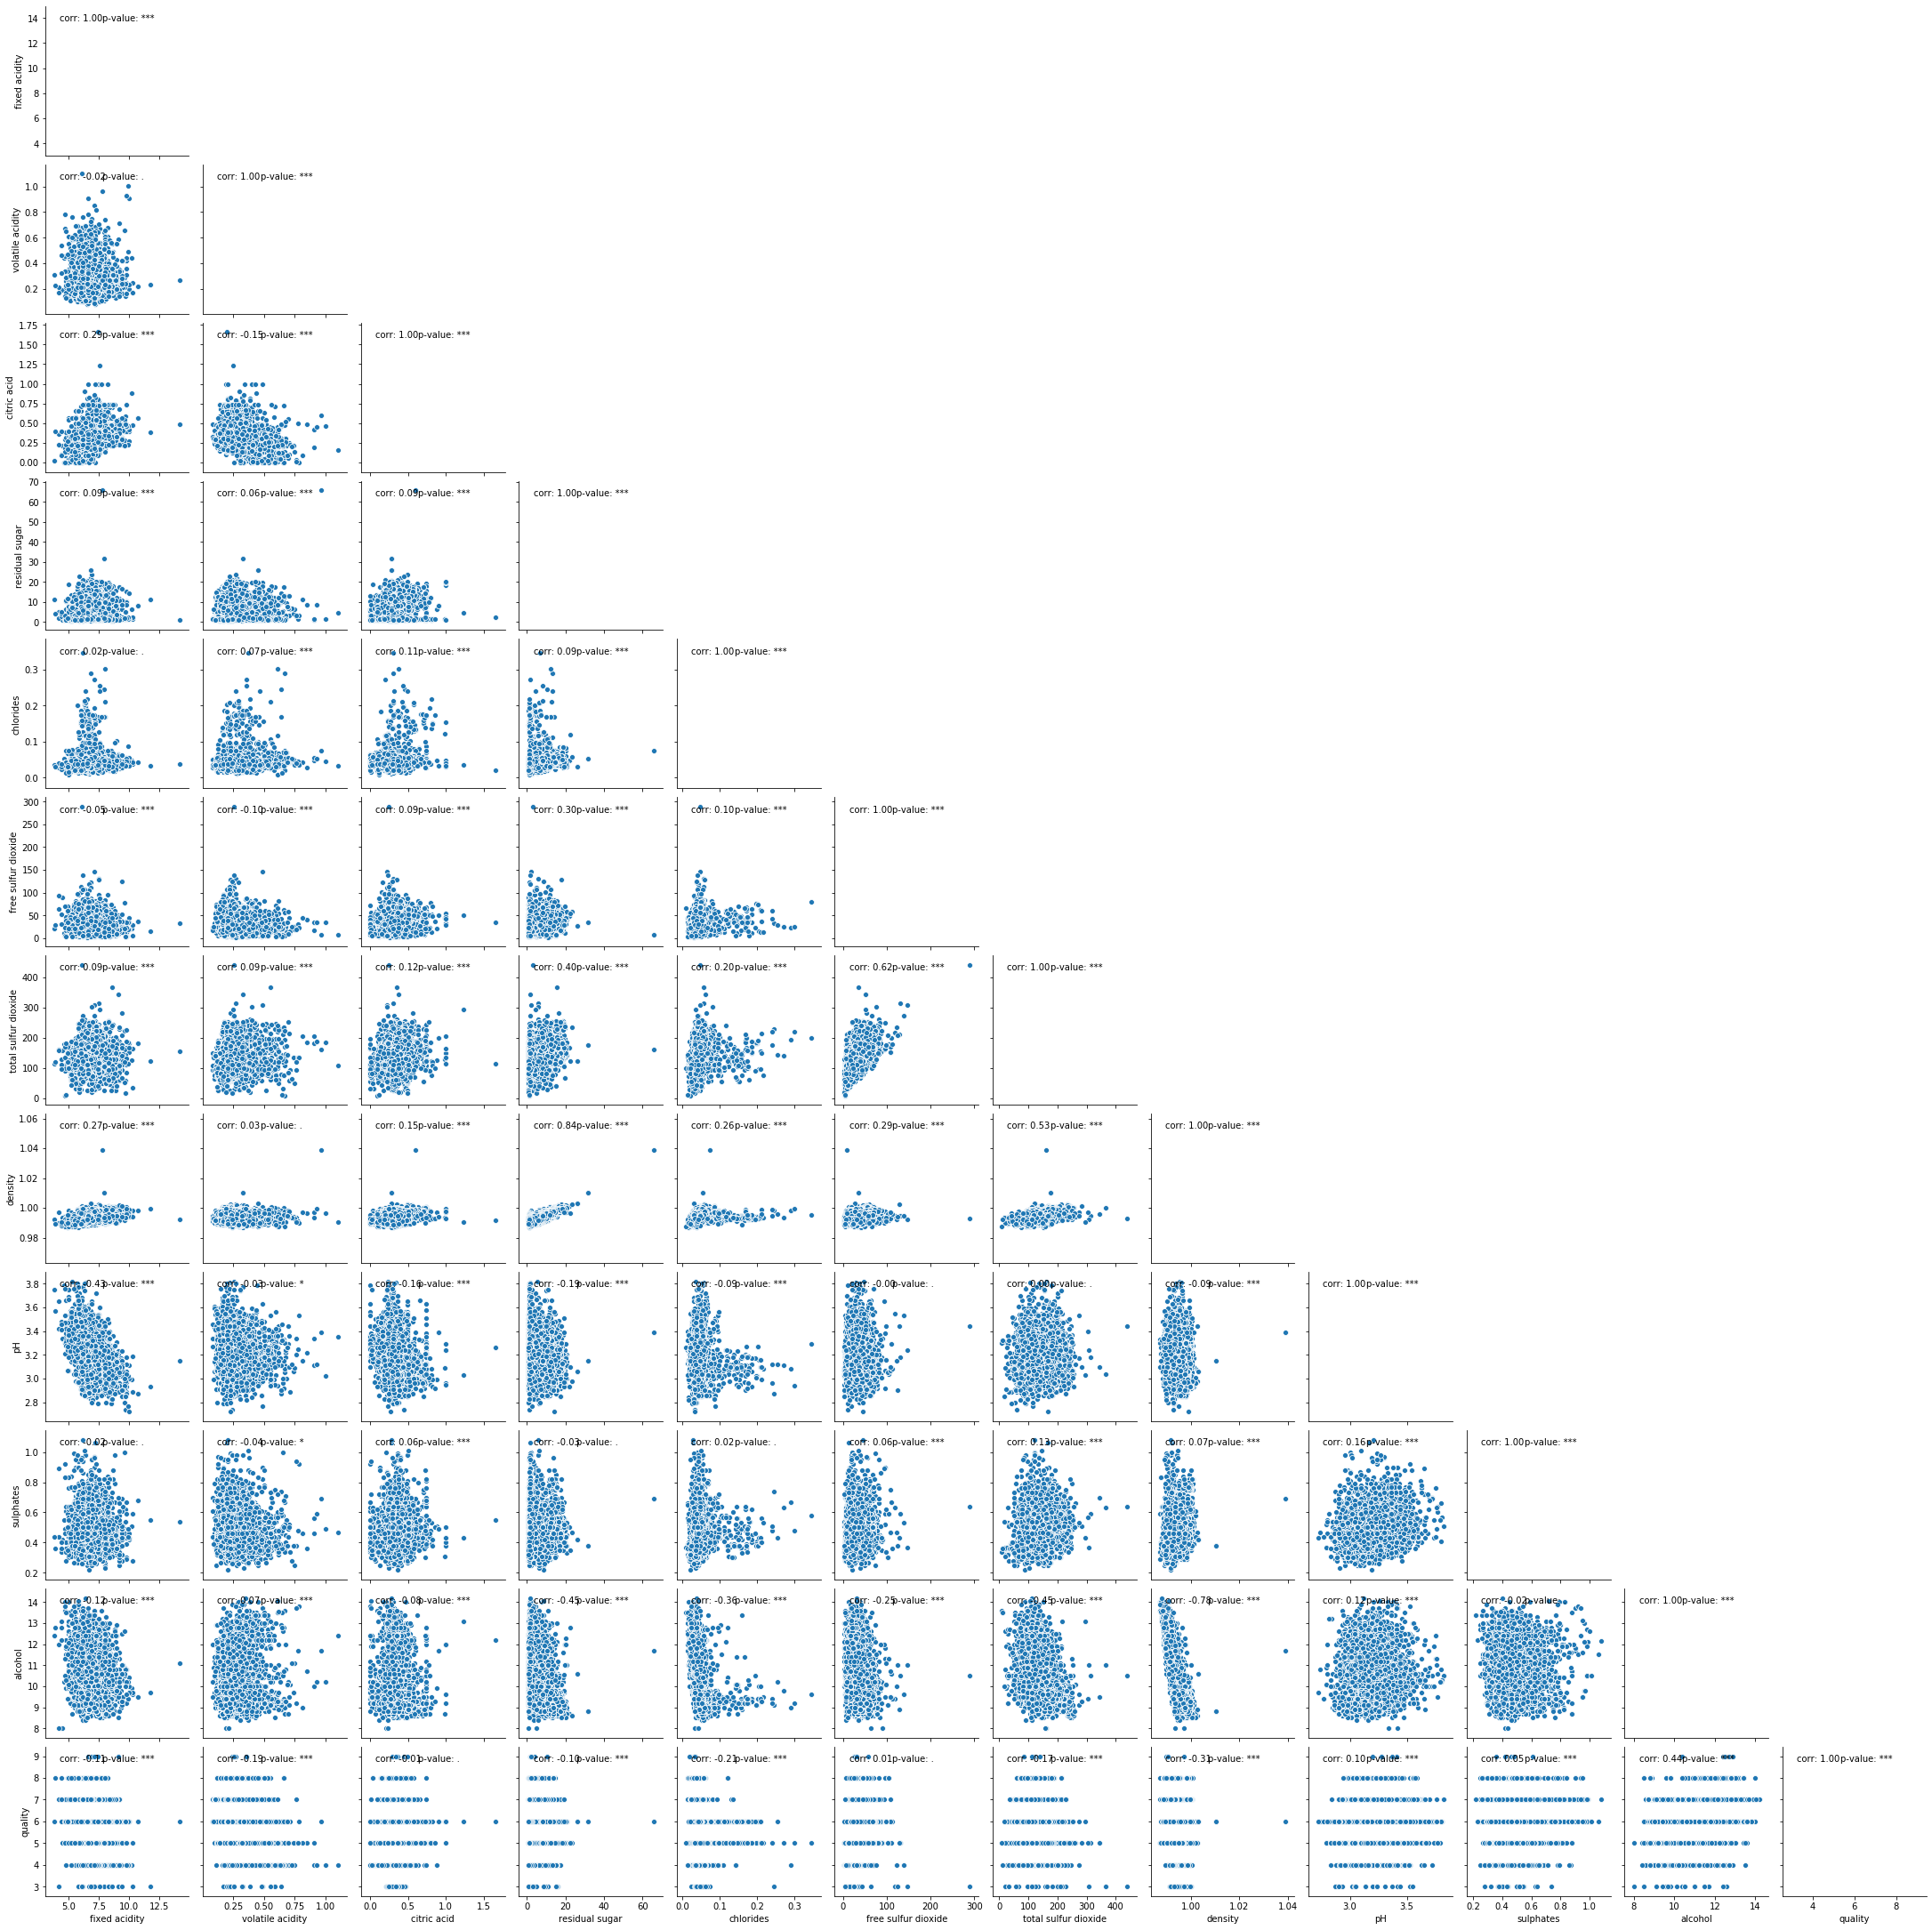

In [56]:
def corrfunc(x, y, **kws):
    (r, p) = pearsonr(x, y)
    
    if (p < 0.05 and p >= 0.01):
        sign = "*"
    elif (p < 0.01 and p >= 0.001):
        sign = "**"
    elif (p < 0.001 and p >= 0):
        sign = "***"
    else:
        sign = "."
    
    ax = plt.gca()
    ax.annotate("corr: {:.2f} ".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    ax.annotate(f"p-value: {sign}",
                xy=(.4, .9), xycoords=ax.transAxes)

def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)
    
graph = sns.pairplot(whiteDF)
graph.map_upper(hide_current_axis)
graph.map_diag(hide_current_axis)
graph.map(corrfunc)

In [42]:
alpha = 0.05
for i in range(whiteDF.shape[1]-1):
    cor_i = pearsonr(whiteDF.quality, whiteDF.iloc[:,i])
    print("Correlation & p-value between quality and", whiteDF.columns[i], "is:")
    print(cor_i)
    if (cor_i[1] < alpha):
        print("significant")
    else:
        print("insignificant")
    print("\n")

Correlation & p-value between quality and fixed acidity is:
(-0.11366283071302202, 1.4798856790558785e-15)
significant


Correlation & p-value between quality and volatile acidity is:
(-0.19472296892113952, 4.673261270709255e-43)
significant


Correlation & p-value between quality and citric acid is:
(-0.0092090908839756, 0.5193459380152076)
insignificant


Correlation & p-value between quality and residual sugar is:
(-0.09757682889469574, 7.724004684826861e-12)
significant


Correlation & p-value between quality and chlorides is:
(-0.20993441094676826, 6.506541750083377e-50)
significant


Correlation & p-value between quality and free sulfur dioxide is:
(0.008158067123436294, 0.5681271459251901)
insignificant


Correlation & p-value between quality and total sulfur dioxide is:
(-0.17473721759706792, 6.991898124269822e-35)
significant


Correlation & p-value between quality and density is:
(-0.3071233127347374, 1.7279878711532392e-107)
significant


Correlation & p-value between qualit

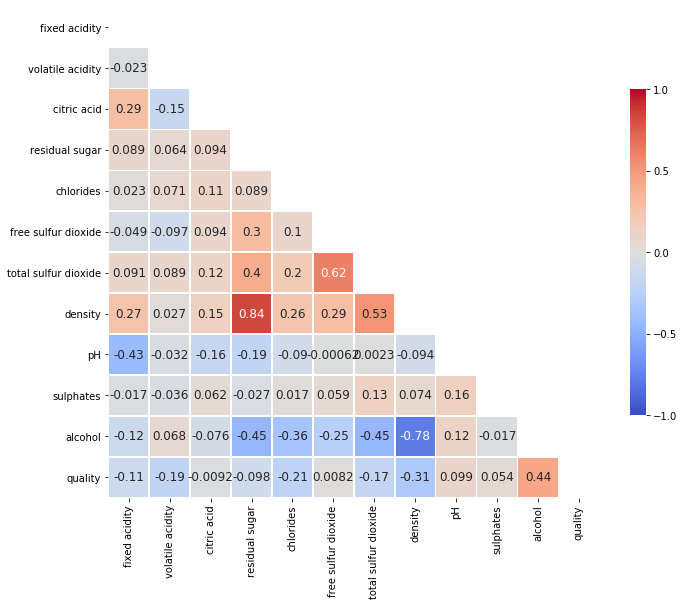

In [46]:
df_corr = whiteDF.corr()

# df_dummy = pd.get_dummies(redDF.htype)
# df = pd.concat([redDF, df_dummy], axis = 1)

mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 15))

heatmap = sns.heatmap(df_corr,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = "coolwarm",
                      cbar_kws = {'shrink': .4,
                                "ticks" : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 12})

#add the column names as labels
ax.set_yticklabels(df_corr.columns, rotation = 0)
ax.set_xticklabels(df_corr.columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

`volatile acidity`, `alcohol`

In [ ]:
corrtest = list(pearsonr(redDF.quality, redDF['volatile acidity']))
f'{corrtest[1]:.60f}'

In [ ]:
X = whiteDF.iloc[:,:-1]
y = whiteDF.quality

In [ ]:
X

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
X_train = np.array(X_train)
X_train

In [ ]:
y_test = np.array(y_test)

In [ ]:
model = LinearRegression().fit(X_train, y_train)

In [ ]:
model.score(X_train, y_train)

In [ ]:
model._residues

In [ ]:
y_pred = model.predict(X_test)

In [ ]:


# plt.hist(residue)
sns.residplot(residue, y_test)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
X_train1 = smApi.add_constant(X_train)
X_train1

In [ ]:
model1 = smApi.OLS(y_train, X_train1)

In [ ]:
model1.resid

In [ ]:
results = model1.fit()

In [ ]:
results.summary()

In [ ]:
model1.predict(y_test)